# Geospatial Data with Better Police conntrol and prediction

## Importing Libraries and Setting up the Environment

In [45]:
CONSTANTS = {
    "TOP_LEFT": (51.699997, -0.5999968),
    "BOTTOM_RIGHT": (51.280014, 0.4199937),
}


In [46]:
import pandas as pd

# Combine and Clean Data 

In [47]:
poi = pd.read_csv("clean_data/poi.csv")
uk_police_data = pd.read_csv("clean_data/uk_police_data.csv")


In [51]:
uk_police_data["Outcome type"].unique()

array(['Suspect charged', 'Unable to prosecute suspect',
       'Action to be taken by another organisation',
       'Formal action is not in the public interest',
       'Offender given penalty notice',
       'Further investigation is not in the public interest',
       'Suspect charged as part of another case'], dtype=object)

In [50]:
# Remove rows with weak outcomes


In [52]:
# poi.lon.min(), uk_police_data.Longitude.min(), poi.lon.max(), uk_police_data.Longitude.max(), poi.lat.min(), uk_police_data.Latitude.min(), poi.lat.max(), uk_police_data.Latitude.max()

# print above nicely
print(
    f"poi.lon.min(): {poi.lon.min()}\nuk_police_data.Longitude.min(): {uk_police_data.Longitude.min()}\npoi.lon.max(): {poi.lon.max()}\nuk_police_data.Longitude.max(): {uk_police_data.Longitude.max()}\npoi.lat.min(): {poi.lat.min()}\nuk_police_data.Latitude.min(): {uk_police_data.Latitude.min()}\npoi.lat.max(): {poi.lat.max()}\nuk_police_data.Latitude.max(): {uk_police_data.Latitude.max()}"
)

poi.lon.min(): -0.5999968
uk_police_data.Longitude.min(): -5.269406
poi.lon.max(): 0.4199937
uk_police_data.Longitude.max(): 1.731511
poi.lat.min(): 51.280014
uk_police_data.Latitude.min(): 50.239385
poi.lat.max(): 51.699997
uk_police_data.Latitude.max(): 54.992489


In [53]:
# top left and bottom right of the POI data
poi_top_left = (poi.lon.min(), poi.lat.max())
poi_bottom_right = (poi.lon.max(), poi.lat.min())
poi_top_left,poi_bottom_right

((-0.5999968, 51.699997), (0.4199937, 51.280014))

In [54]:
def filter_by_month(df, month):
    return df[df["Month"] == month]

def filter_by_months(df, months):
    return df[df["Month"].isin(months)]

def filter_by_year(df, year):
    return df[df["Month"].str.contains(year)]

filter_by_month(uk_police_data, "2019-10")

,Month,Longitude,Latitude,Outcome type
1,2019-10,-0.073850,51.509313,Suspect charged
4,2019-10,-0.081620,51.516814,Suspect charged
9,2019-10,-0.084967,51.512598,Suspect charged
10,2019-10,-0.079786,51.517576,Suspect charged
12,2019-10,-0.059878,51.518660,Suspect charged
...,...,...,...,...
4211,2019-10,-0.216103,51.506635,Suspect charged
4212,2019-10,-0.124673,51.509777,Suspect charged
4213,2019-10,-0.138931,51.514932,Suspect charged
4214,2019-10,-0.144179,51.518091,Suspect charged


In [55]:
def within_bounds(lat:float, long:float):
    (top_left_lat, top_left_long), (bottom_right_lat, bottom_right_long) = CONSTANTS["TOP_LEFT"], CONSTANTS["BOTTOM_RIGHT"]
    return top_left_lat >= lat >= bottom_right_lat and top_left_long <= long <= bottom_right_long

def lat_long_to_id(lat:float, long:float, steps_x=40, steps_y=40):
    if not within_bounds(lat, long):
        return -1
    (top_left_lat, top_left_long), (bottom_right_lat, bottom_right_long) = CONSTANTS["TOP_LEFT"], CONSTANTS["BOTTOM_RIGHT"]
    
    width = top_left_long - bottom_right_long
    height = top_left_lat - bottom_right_lat

    x_step = width / steps_x
    y_step = height / steps_y

    x = int((long - bottom_right_long) / x_step)
    y = int((lat - bottom_right_lat) / y_step)

    return x + y * steps_x


### Map latitude and longitude to the grid id

In [56]:
poi["id"] = poi.apply(lambda row: lat_long_to_id(row["lat"], row["lon"]), axis=1)
poi.head()

,id,lon,lat,amenity
0,942,-0.152817,51.524364,waste_basket
1,940,-0.093388,51.529125,bicycle_rental
2,942,-0.143121,51.528263,advice
3,981,-0.140276,51.534256,bicycle_parking
4,1224,-0.194608,51.600842,pub


In [57]:
uk_police_data["id"] = uk_police_data.apply(lambda row: lat_long_to_id(row["Latitude"], row["Longitude"]), axis=1)
uk_police_data.head()

/var/folders/t6/hq232vhj0_bgznz9gy6z1ywh0000gp/T/ipykernel_39352/2361544070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_police_data["id"] = uk_police_data.apply(lambda row: lat_long_to_id(row["Latitude"], row["Longitude"]), axis=1)


,Month,Longitude,Latitude,Outcome type,id
1,2019-10,-0.073850,51.509313,Suspect charged,859
4,2019-10,-0.081620,51.516814,Suspect charged,899
9,2019-10,-0.084967,51.512598,Suspect charged,899
10,2019-10,-0.079786,51.517576,Suspect charged,899
12,2019-10,-0.059878,51.518660,Suspect charged,898


In [58]:
# remove rows with -1 id
poi = poi[poi["id"] != -1]
uk_police_data = uk_police_data[uk_police_data["id"] != -1]

In [59]:
# remove lat and lon columns, we don't need them anymore
poi = poi.drop(columns=["lat", "lon"])
uk_police_data = uk_police_data.drop(columns=["Latitude", "Longitude"])


In [60]:
# Crimes in 2020
# crimes_2020 = filter_by_month(uk_police_data, "2020-01")

In [61]:
# Crimes in 2020 grouped by id
crimes_2020 = filter_by_year(uk_police_data, "2020").drop(columns=["Month"]).groupby("id").count().reset_index()
crimes_2020 = crimes_2020.rename(columns={"Outcome type": "Crime Count"})

# Crimes in 2021 grouped by id
crimes_2021 = filter_by_year(uk_police_data, "2021").drop(columns=["Month"]).groupby("id").count().reset_index()
crimes_2021 = crimes_2021.rename(columns={"Outcome type": "Crime Count"})

In [62]:
# Create 1 hot encoded columns for each amenity
poi_main = poi.join(poi["amenity"].str.get_dummies(sep=";"))
poi_main = poi_main.drop(columns=["amenity"])

# Group by id and sum the 1 hot encoded columns
poi_main = poi_main.groupby("id").sum().reset_index()
poi_main


,id,theatre,Childrens Centre,Housing Office,Men's Lounge,Nutritionist,Salon One Six Seven,Samuel Court,Scout_hut,Scouts,...,waste_transfer_station,water_fountain,water_point,water_pump,watering_place,weapon_bin,weathervane,weighbridge,yes,youth_project
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412,1593,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1413,1595,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1414,1597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1415,1599,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
# print all columns in poi_main sum
poi_main.drop(columns=["id"]).sum().sort_values(ascending=False)
# drop bench, post_box, waste_basket, bicycle_parking
poi_main = poi_main.drop(columns=["bench", "post_box", "waste_basket", "bicycle_parking"])
poi_main.drop(columns=["id"]).sum().sort_values(ascending=False)

restaurant             5363
cafe                   3957
fast_food              3459
telephone              3190
pub                    1806
                       ... 
hospital_department       1
housing_office            1
information_centre        1
interior                  1
youth_project             1
Length: 318, dtype: int64

In [64]:
# merge crimes_2020 and poi_main
merged_2020 = crimes_2020.merge(poi_main, on="id", how="left")
merged_2020 = merged_2020.fillna(0)
merged_2020

,id,Crime Count,theatre,Childrens Centre,Housing Office,Men's Lounge,Nutritionist,Salon One Six Seven,Samuel Court,Scout_hut,...,waste_transfer_station,water_fountain,water_point,water_pump,watering_place,weapon_bin,weathervane,weighbridge,yes,youth_project
0,60,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,61,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,63,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,95,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,101,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,1551,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
784,1552,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
785,1576,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
786,1584,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# merge crimes_2021 and poi_main
merged_2021 = crimes_2021.merge(poi_main, on="id", how="left")
merged_2021 = merged_2021.fillna(0)
merged_2021

,id,Crime Count,theatre,Childrens Centre,Housing Office,Men's Lounge,Nutritionist,Salon One Six Seven,Samuel Court,Scout_hut,...,waste_transfer_station,water_fountain,water_point,water_pump,watering_place,weapon_bin,weathervane,weighbridge,yes,youth_project
0,20,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,44,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,60,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,61,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,95,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,1536,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
772,1537,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,1538,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
774,1540,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# save merged_2020 and merged_2021 to csv
merged_2020.to_csv("clean_data/merged_2020.csv", index=False)
merged_2021.to_csv("clean_data/merged_2021.csv", index=False)

# Model Building!

## Train Test Split

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [68]:
# split merged_2020 into train and test
train, test = train_test_split(merged_2020, test_size=0.2, random_state=42)

# split train into X_train and y_train
X_train = train.drop(columns=["id", "Crime Count"])
y_train = train["Crime Count"]

# split test into X_test and y_test
X_test = test.drop(columns=["id", "Crime Count"])
y_test = test["Crime Count"]

## Models

### Linear Regression

In [69]:
# create linear regression model
model = LinearRegression()

# train model
model.fit(X_train, y_train)

# predict y_test
y_pred = model.predict(X_test)

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.2f" % mse)

# calculate r2 score
r2 = r2_score(y_test, y_pred)
print("R2 score: %.2f" % r2)


Mean squared error: 10064.10
R2 score: 0.11


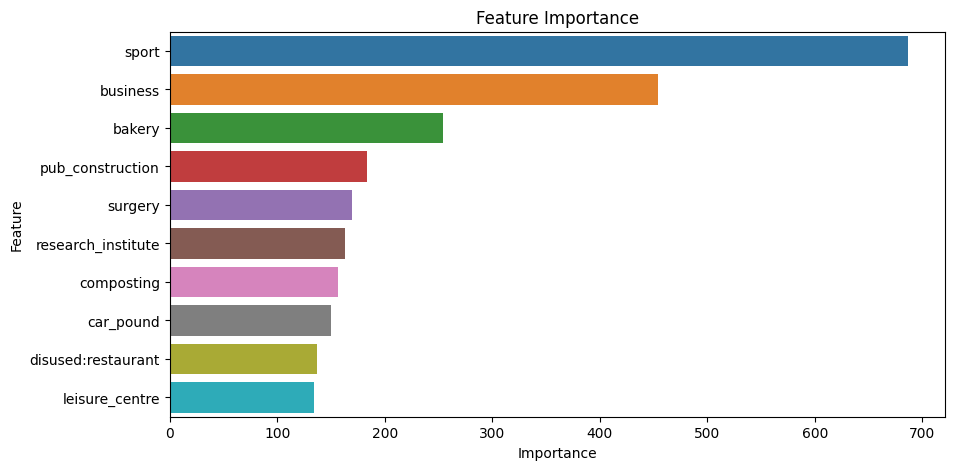

In [70]:
# plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.DataFrame({"Feature": X_train.columns, "Importance": model.coef_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# plot top 10 features with highest importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(10))
plt.title("Feature Importance")
plt.show()


### Random Forest

In [71]:
# create random forest model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)

# train model
model.fit(X_train, y_train)

# predict y_test
y_pred = model.predict(X_test)

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.2f" % mse)

# calculate r2 score
r2 = r2_score(y_test, y_pred)
print("R2 score: %.2f" % r2)

Mean squared error: 3408.59
R2 score: 0.70


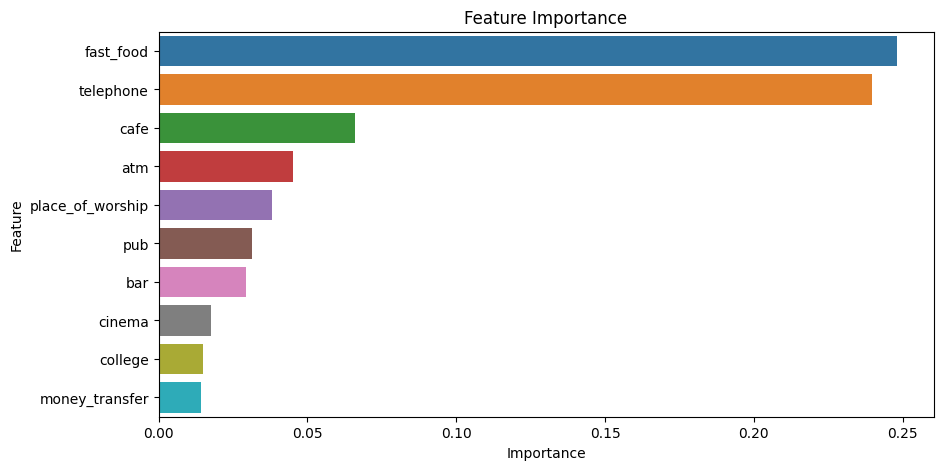

In [72]:
# plot feature importance
feature_importance = pd.DataFrame({"Feature": X_train.columns, "Importance": model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# plot top 10 features with highest importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(10))
plt.title("Feature Importance")
plt.show()

### xgboost

In [73]:
# create xgboost model
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, random_state=42)

# train model
model.fit(X_train, y_train)

# predict y_test
y_pred = model.predict(X_test)

# calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.2f" % mse)

# calculate r2 score
r2 = r2_score(y_test, y_pred)
print("R2 score: %.2f" % r2)

Mean squared error: 3650.27
R2 score: 0.68


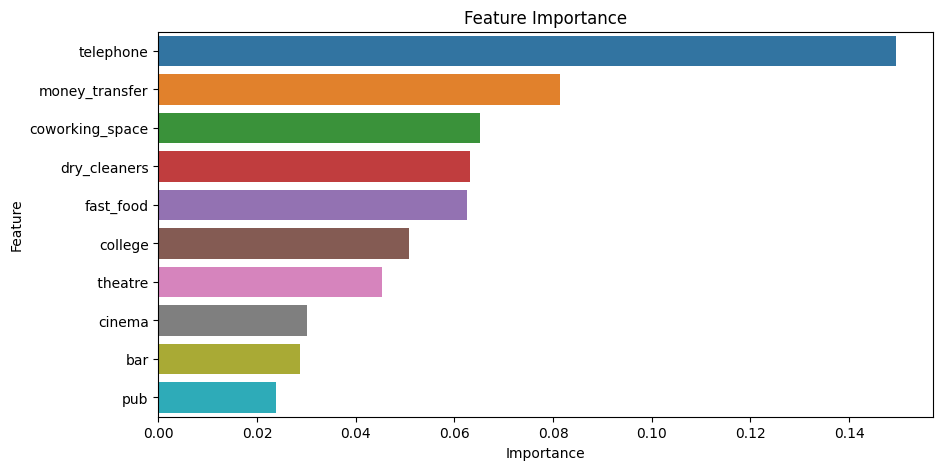

In [74]:
# plot feature importance
feature_importance = pd.DataFrame({"Feature": X_train.columns, "Importance": model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# plot top 10 features with highest importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(10))

plt.title("Feature Importance")
plt.show()
